In [11]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from brokenaxes import brokenaxes
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
from joblib import Parallel, delayed

# Directories

In [12]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'
norm = 'GWKR'

In [13]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic = f'/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_inter{norm}/'
# Directory of LAS processed data
dir_las = f'/home/louiscam/projects/gpcr/save/LAS_results/IMR90/{norm}/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
saving_main_dir = '/home/louiscam/projects/gpcr/save/figures_main/'
saving_supp_dir = '/home/louiscam/projects/gpcr/save/figures_supplement/'

In [14]:
# Load mapping between loci and adhesome genes
with open(saving_dir+'locus2gene.pkl', 'rb') as f:
    locus2gene = pickle.load(f)
# Load active adhesome genes   
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
# Load active adhesome TF genes   
with open(saving_dir+'active_lung_adhesome_tf_genes.pkl', 'rb') as f:
    active_lung_adhesome_tf_genes = pickle.load(f)
# Load active genes   
with open(saving_dir+'active_genes.pkl', 'rb') as f:
    active_genes = pickle.load(f)
# Load active random non-adhesome genes   
with open(saving_dir+'random_active_nonadh_genes.pkl', 'rb') as f:
    random_active_nonadh_genes = pickle.load(f)    

# Function to graph using intermingling regions

In [15]:
# For each chromosome pair and each intermingling region, create a graph and edge list

def create_las_graph(dir_las, gene_list, tf_gene_list):

    chr_list = np.arange(1,23,1)
    chr_pairs = list(itertools.combinations(chr_list, 2))
    intermingling_graphs = {}
    intermingling_adhesome_graphs = {}

    for chr1, chr2 in tqdm(chr_pairs):

        # Load intermingling regions
        intermingling_regions_chr1chr2_fname = dir_las+f'intermingling_regions.chr{chr1}_chr{chr2}.avg_filt.csv'
        intermingling_regions_chr1chr2 = pd.read_csv(intermingling_regions_chr1chr2_fname, 
                                                     header=0, index_col=0, sep=',')

        if len(intermingling_regions_chr1chr2)==0:
            # print(f'Chromosomes {chr1} and {chr2} do not have intermingling regions')
            pass
        else:
            # Sort regions by LAS score
            intermingling_regions_chr1chr2 = intermingling_regions_chr1chr2.sort_values(by=['score'], ascending=False)

            # For each intermingling region, list loci on chr1 and chr2
            intermingling_regions_chr1chr2['loci_chr1'] = intermingling_regions_chr1chr2.apply(
                lambda row: np.arange(row[0], row[1]+1, resol).astype(int), axis=1
            )
            intermingling_regions_chr1chr2['loci_chr1'] = intermingling_regions_chr1chr2['loci_chr1'].apply(
                lambda loci: [f'chr_{chr1}_loc_{loc}' for loc in loci]
            )
            intermingling_regions_chr1chr2['loci_chr2'] = intermingling_regions_chr1chr2.apply(
                lambda row: np.arange(row[2], row[3]+1, resol).astype(int), axis=1
            )
            intermingling_regions_chr1chr2['loci_chr2'] = intermingling_regions_chr1chr2['loci_chr2'].apply(
                lambda loci: [f'chr_{chr2}_loc_{loc}' for loc in loci]
            ) 

            # Create edge list for chr1/chr2
            edge_list = intermingling_regions_chr1chr2[['loci_chr1', 'loci_chr2', 'score']]
            # Add intraX edges
            intraX_edge_list_chr1 = edge_list.loc[:,['loci_chr1', 'loci_chr1', 'score']]
            intraX_edge_list_chr1.columns = ['loci_chr1', 'loci_chr2', 'score']
            intraX_edge_list_chr2 = edge_list.loc[:,['loci_chr2', 'loci_chr2', 'score']]
            intraX_edge_list_chr2.columns = ['loci_chr1', 'loci_chr2', 'score']
            edge_list = pd.concat([edge_list, intraX_edge_list_chr1, intraX_edge_list_chr2], ignore_index=True, axis=0)
            edge_list = edge_list.explode(column=['loci_chr1'])
            edge_list = edge_list.explode(column=['loci_chr2'])
            # Drop self-edges
            edge_list = edge_list[(edge_list['loci_chr1'] != edge_list['loci_chr2'])]
            # Aggregate duplicated edges
            edge_list = edge_list.sort_values(['loci_chr1', 'loci_chr2'])
            edge_list = edge_list.groupby(['loci_chr1', 'loci_chr2']).agg('max')
            edge_list = edge_list.reset_index()

            # Create graph
            G = nx.from_pandas_edgelist(df=edge_list, source='loci_chr1', target='loci_chr2', edge_attr=['score'])

            # Add node attributes
            nx.set_node_attributes(G, 
                                   {loc: 'chr'+loc.split('_')[1] for loc in G.nodes}, 
                                   'chrom')
            nx.set_node_attributes(G, 
                                   {loc: locus2gene[loc] if (loc in locus2gene.keys()) else [] for loc in G.nodes}, 
                                   'genes')
            nx.set_node_attributes(G, 
                                   {loc: len(locus2gene[loc]) if (loc in locus2gene.keys()) else [] for loc in G.nodes}, 
                                   'n_genes')
            nx.set_node_attributes(G, 
                                   {loc: [g for g in locus2gene[loc] if g in gene_list] 
                                    if (loc in locus2gene.keys()) else [] for loc in G.nodes}, 
                                   'adhesome_genes')
            nx.set_node_attributes(G, 
                                   {loc: len([g for g in locus2gene[loc] if g in gene_list]) 
                                    if (loc in locus2gene.keys()) else 0 for loc in G.nodes}, 
                                   'n_adhesome_genes')
            nx.set_node_attributes(G, 
                                   {loc: [g for g in locus2gene[loc] if g in tf_gene_list] 
                                    if (loc in locus2gene.keys()) else [] for loc in G.nodes}, 
                                   'active_lung_adhesome_tf_genes')
            nx.set_node_attributes(G, 
                                   {loc: len([g for g in locus2gene[loc] if g in tf_gene_list]) 
                                    if (loc in locus2gene.keys()) else 0 for loc in G.nodes}, 
                                   'n_active_lung_adhesome_tf_genes')
            nx.set_node_attributes(G, 
                                   {loc: str(len([g for g in locus2gene[loc] if g in tf_gene_list])>0) 
                                    if (loc in locus2gene.keys()) else 'False' for loc in G.nodes}, 
                                   'active_lung_adhesome_tf_genes_present')
            nx.set_node_attributes(G, 
                                   {loc: [g for g in locus2gene[loc] 
                                          if ((g in gene_list) or (g in tf_gene_list))] 
                                    if (loc in locus2gene.keys()) else [] for loc in G.nodes}, 
                                   'adhesome_and_tf_genes')

            # Save graph
            intermingling_graphs[f'chr{chr1}_chr{chr2}'] = G
            n_adhesome_genes_dict = nx.get_node_attributes(G, 'n_adhesome_genes')
            n_active_lung_adhesome_tf_genes_dict = nx.get_node_attributes(G, 'n_active_lung_adhesome_tf_genes')
            non_adhesome_nodes = [loc for loc in G.nodes 
                                  if ((n_adhesome_genes_dict[loc]==0) and 
                                      (n_active_lung_adhesome_tf_genes_dict[loc]==0))]
            G.remove_nodes_from(non_adhesome_nodes)
            intermingling_adhesome_graphs[f'chr{chr1}_chr{chr2}'] = G

    G = nx.compose_all(list(intermingling_adhesome_graphs.values()))
    return(G)

# Create LAS graph for adhesome

In [16]:
# Create LAS graph for adhesome genes
G = create_las_graph(dir_las, active_adhesome_genes, active_lung_adhesome_tf_genes)
print(nx.info(G))
print(f'Density: {nx.density(G)}')

100%|██████████| 231/231 [00:18<00:00, 12.44it/s]


Name: 
Type: Graph
Number of nodes: 224
Number of edges: 7006
Average degree:  62.5536
Density: 0.28050928891736066


In [21]:
# Compare adhesome LAS graph to random non adhesome genes LAS graph
n_adhesome = len(active_adhesome_genes)+len(active_lung_adhesome_tf_genes)
active_non_adhesome_genes = set(active_genes)-set(active_adhesome_genes)-set(active_lung_adhesome_tf_genes)
active_non_adhesome_genes = list(active_non_adhesome_genes)

n_rep = 500
graph_densities = []
graph_avg_degrees = []

def build_random_las_graph(seed):
    np.random.seed(seed)
    random_non_adhesome_genes = np.random.choice(a=active_non_adhesome_genes, size=n_adhesome, replace=False)
    G_random = create_las_graph(dir_las, random_non_adhesome_genes, [])
    return([nx.density(G_random), np.mean(list(dict(nx.degree(G_random)).values()))])

out = Parallel(n_jobs=os.cpu_count()-2)(delayed(build_random_las_graph)(i**2) for i in tqdm(range(n_rep)))
out = np.array(out)
graph_densities = out[:,0]
graph_avg_degrees = out[:,1]

100%|██████████| 500/500 [12:16<00:00,  1.47s/it]


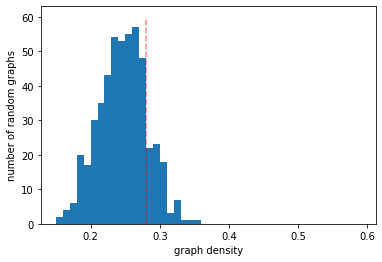

p-value = 0.15


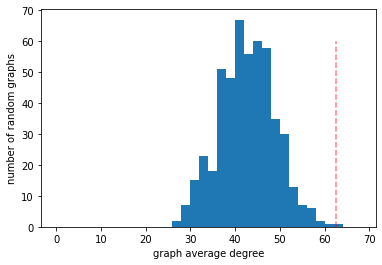

p-value = 0.0


In [24]:
# Plot
plt.figure()
plt.hist(graph_densities, bins=np.arange(0.15, 0.6, 0.01))
plt.vlines(x=nx.density(G), ymin=0, ymax=60, color='red', linestyle='dashed', alpha=0.5)
plt.xlabel('graph density')
plt.ylabel('number of random graphs')
plt.show()
print(f'p-value = {np.mean(graph_densities>=nx.density(G))}')

plt.figure()
plt.hist(graph_avg_degrees, bins=np.arange(0, 70, 2))
plt.vlines(x=np.mean(list(dict(nx.degree(G)).values())), ymin=0, ymax=60, color='red', linestyle='dashed', alpha=0.5)
plt.xlabel('graph average degree')
plt.ylabel('number of random graphs')
plt.show()
print(f'p-value = {np.mean(graph_avg_degrees>np.mean(list(dict(nx.degree(G)).values())))}')

In [17]:
# Info on nodes and edges
graph_nodes = oi.get_networkx_graph_as_dataframe_of_nodes(G)
graph_edges = oi.get_networkx_graph_as_dataframe_of_edges(G)

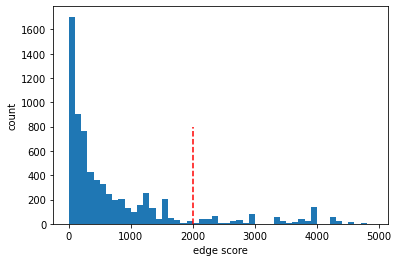

In [18]:
# Plot distribution of edge weights
t = 2000
plt.figure()
plt.hist(graph_edges['score'].values, bins = np.arange(0,5000, 100))
plt.vlines(x=t, ymin=0, ymax=800, color='red', linestyle='dashed')
plt.xlabel('edge score')
plt.ylabel('count')
plt.show()

In [41]:
# Threshold edges
score_dict = nx.get_edge_attributes(G, 'score')
edges2remove = [e for e in G.edges if score_dict[e]<t]
G.remove_edges_from(edges2remove)
G.remove_nodes_from(list(nx.isolates(G)))
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 52
Number of edges: 760
Average degree:  29.2308


In [259]:
# Save network as html
oi.output_networkx_graph_as_interactive_html(G, output_dir='/home/louiscam/projects/gpcr/code/analysis_LAS/',
                                            filename='las_graph.html')

PosixPath('/home/louiscam/projects/gpcr/code/analysis_LAS/las_graph_random.html')

# Another way to represent the graph where nodes = clusters

In [187]:
# For each chromosome pair and each intermingling region, create a graph and edge list

chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))

node_attribute_chrom = {}
edge_lists = []

for chr1, chr2 in tqdm(chr_pairs):

    # Load intermingling regions
    intermingling_regions_chr1chr2_fname = dir_las+f'intermingling_regions.chr{chr1}_chr{chr2}.avg_filt.csv'
    intermingling_regions_chr1chr2 = pd.read_csv(intermingling_regions_chr1chr2_fname, 
                                                 header=0, index_col=0, sep=',')

    if len(intermingling_regions_chr1chr2)==0:
        print(f'Chromosomes {chr1} and {chr2} do not have intermingling regions')
    else:
        # Sort regions by LAS score
        intermingling_regions_chr1chr2 = intermingling_regions_chr1chr2.sort_values(by=['score'], ascending=False)

        # For each intermingling region, list loci on chr1 and chr2
        intermingling_regions_chr1chr2['loci_chr1'] = intermingling_regions_chr1chr2.apply(
            lambda row: np.arange(row[0], row[1]+1, resol).astype(int), axis=1
        )
        intermingling_regions_chr1chr2['loci_chr1'] = intermingling_regions_chr1chr2['loci_chr1'].apply(
            lambda loci: [f'chr_{chr1}_loc_{loc}' for loc in loci]
        )
        intermingling_regions_chr1chr2['loci_chr2'] = intermingling_regions_chr1chr2.apply(
            lambda row: np.arange(row[2], row[3]+1, resol).astype(int), axis=1
        )
        intermingling_regions_chr1chr2['loci_chr2'] = intermingling_regions_chr1chr2['loci_chr2'].apply(
            lambda loci: [f'chr_{chr2}_loc_{loc}' for loc in loci]
        )
        
        # List adhesome gene in loci_chr1 and loci_chr2
        intermingling_regions_chr1chr2['adhesome_chr1'] = intermingling_regions_chr1chr2['loci_chr1'].apply(
            lambda loci: sorted(itertools.chain.from_iterable([[g for g in locus2gene[loc] 
                           if (g in active_adhesome_genes)] for loc in loci if (loc in locus2gene.keys())]))
        )
        intermingling_regions_chr1chr2['adhesome_chr2'] = intermingling_regions_chr1chr2['loci_chr2'].apply(
            lambda loci:  sorted(itertools.chain.from_iterable([[g for g in locus2gene[loc] 
                           if (g in active_adhesome_genes)] for loc in loci if (loc in locus2gene.keys())]))
        )
        
        # Name cluster 1 and 2 by their genes
        intermingling_regions_chr1chr2['source'] = intermingling_regions_chr1chr2['adhesome_chr1'].apply(
            lambda gene_list: ', '.join(sorted(set(gene_list)))  
        )
        intermingling_regions_chr1chr2['target'] = intermingling_regions_chr1chr2['adhesome_chr2'].apply(
            lambda gene_list: ', '.join(sorted(set(gene_list)))  
        )
        
        # Only keep relationships between clusters containing adhesome genes
        intermingling_regions_chr1chr2 = intermingling_regions_chr1chr2[
            (intermingling_regions_chr1chr2['source'] != '') & (intermingling_regions_chr1chr2['target'] != '')
        ]
        
        # Create edge list
        intermingling_regions_chr1chr2 = intermingling_regions_chr1chr2[['source', 'target', 'score']]
        edge_lists.append(intermingling_regions_chr1chr2)
        for source in intermingling_regions_chr1chr2['source']:
            node_attribute_chrom[source] = 'chr'+str(chr1)
        for target in intermingling_regions_chr1chr2['target']:
            node_attribute_chrom[target] = 'chr'+str(chr2)

 26%|██▌       | 60/231 [00:01<00:04, 42.12it/s]

Chromosomes 3 and 18 do not have intermingling regions


100%|██████████| 231/231 [00:07<00:00, 31.53it/s]


In [188]:
# Create final edge list and graph
edge_list = pd.concat(edge_lists, axis=0)
G = nx.from_pandas_edgelist(df=edge_list, source='source', target='target', edge_attr=['score'])
nx.set_node_attributes(G, node_attribute_chrom, 'chrom')
print(nx.info(G))
print(f'Density: {nx.density(G)}')

Name: 
Type: Graph
Number of nodes: 160
Number of edges: 1225
Average degree:  15.3125
Density: 0.09630503144654089


In [189]:
# Determine nodes that have at least one gene in common
nodes = list(G.nodes)
common_genes = pd.DataFrame(0, index=nodes, columns=nodes)
for node1, node2 in itertools.combinations(nodes, 2):
    node1_ls = node1.split(', ')
    node2_ls = node2.split(', ')
    common_genes.loc[node1, node2] = len(set.intersection(*[set(node1_ls), set(node2_ls)]))
G_common = nx.from_pandas_adjacency(common_genes>0) 
supernodes = list(nx.connected_components(G_common))

In [190]:
# Contract nodes
for supernode in supernodes:
    supernode_nodes = sorted(list(supernode))
    for node in supernode_nodes[1:]:
        G = nx.contracted_nodes(G, supernode_nodes[0], node)

In [191]:
# Count number of interacting gene pairs (from adhesome network) between two clusters
with open(saving_dir+'adhesome_network_graph.pkl', 'rb') as f:
    adhesome_network = pickle.load(f)

def get_interactions(e, adhesome_network):
    source, target = e
    source_genes = source.split(', ')
    target_genes = target.split(', ')
    interacting_pairs = []
    for g1, g2 in itertools.product(source_genes, target_genes):
        if (g1 in adhesome_network.nodes) & (g2 in adhesome_network.nodes):
            if (g1 in nx.neighbors(adhesome_network, g2)) | (g2 in nx.neighbors(adhesome_network, g1)):
                interacting_pairs.append((g1, g2))
    return(interacting_pairs)
                        
def get_n_interactions(e, adhesome_network):
    source, target = e
    source_genes = source.split(', ')
    target_genes = target.split(', ')
    interacting_pairs = []
    for g1, g2 in itertools.product(source_genes, target_genes):
        if (g1 in adhesome_network.nodes) & (g2 in adhesome_network.nodes):
            if (g1 in nx.neighbors(adhesome_network, g2)) | (g2 in nx.neighbors(adhesome_network, g1)):
                interacting_pairs.append((g1, g2))
    return(len(interacting_pairs))

G_edge_interact_dict = {e: get_interactions(e, adhesome_network) for e in G.edges}
G_edge_n_interact_dict = {e: get_n_interactions(e, adhesome_network) for e in G.edges}

nx.set_edge_attributes(G, G_edge_interact_dict, 'intercluster interactions')
nx.set_edge_attributes(G, G_edge_n_interact_dict, 'number of intercluster interactions')

In [192]:
# Info on nodes and edges
graph_nodes = oi.get_networkx_graph_as_dataframe_of_nodes(G)
graph_edges = oi.get_networkx_graph_as_dataframe_of_edges(G)

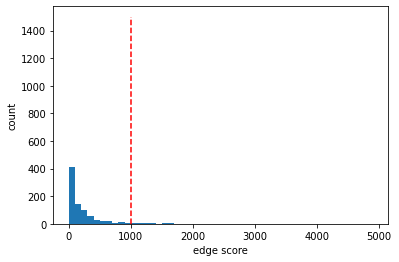

In [193]:
# Plot distribution of edge weights
t = 1000
plt.figure()
plt.hist(graph_edges['score'].values, bins = np.arange(0,5000, 100))
plt.vlines(x=t, ymin=0, ymax=1500, color='red', linestyle='dashed')
plt.xlabel('edge score')
plt.ylabel('count')
plt.show()

In [195]:
# Threshold edges
# score_dict = nx.get_edge_attributes(G, 'score')
# edges2remove = [e for e in G.edges if score_dict[e]<t]
# G.remove_edges_from(edges2remove)
# G.remove_nodes_from(list(nx.isolates(G)))
# print(nx.info(G))

# Flag edges with score below t
score_dict = nx.get_edge_attributes(G, 'score')
nx.set_edge_attributes(
    G, 
    {e: True if score_dict[e]>t else False for e in G.edges}, 
    'high score')

In [196]:
# Save network as html
oi.output_networkx_graph_as_interactive_html(G, output_dir='/home/louiscam/projects/gpcr/code/analysis_LAS/',
                                            filename='las_graph_contracted.html')

PosixPath('/home/louiscam/projects/gpcr/code/analysis_LAS/las_graph_contracted.html')

In [197]:
# Save network to pickle
with open(saving_dir+'las_graph_contracted.pkl', 'wb') as f:
    pickle.dump(G, f)